In [1]:
%matplotlib inline
import os, sys

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib/keras_ex')
#from gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from gkernel.sklearn import RBFClassifier

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
X, y = digits.data, digits.target
X = X / 16
X.shape, X.min(), X.max()

((1797, 64), 0.0, 1.0)

In [4]:
y.shape

(1797,)

In [5]:
N = y.shape[0]
y2 = keras.utils.to_categorical(y, num_classes=10)
y2.shape
index = np.arange(N)
xtrain = X[index[index % 2 != 0],:]
ytrain = y2[index[index % 2 != 0]]
xtest = X[index[index % 2 == 0],:]
yans = y2[index[index % 2 == 0]]

In [53]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, Lasso
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import joblib

from lightgbm import LGBMClassifier

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
def f1_scorer(estimator, X, y):
    pred = estimator.predict(X)
    s = f1_score(y, pred, average='macro')
    return s

## ベンチマーク LogisticRegression

In [48]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [49]:
param_name = "C"
param_range = np.logspace(-3, 3, 7)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [52]:
%%time

train_scores, test_scores = validation_curve(
    LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000),
    xtrain, np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.3s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   0.9s
[CV] C=10.0 ..........................................................
[CV] ........................................... C=10.0, total=   3.5s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   4.0s
[CV] C=1000.0 ........................................................
[CV] ......................................... C=1000.0, total=   4.4s
[CV] C

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   44.3s finished


In [54]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 1.84742147e-02, 1.86177084e-02],
       [1.00000000e-02, 1.82850272e-02, 1.84427988e-02],
       [1.00000000e-01, 8.83084412e-01, 8.17783004e-01],
       [1.00000000e+00, 9.85584329e-01, 9.30447501e-01],
       [1.00000000e+01, 1.00000000e+00, 9.42338391e-01],
       [1.00000000e+02, 1.00000000e+00, 9.40013455e-01],
       [1.00000000e+03, 1.00000000e+00, 9.42379012e-01]])

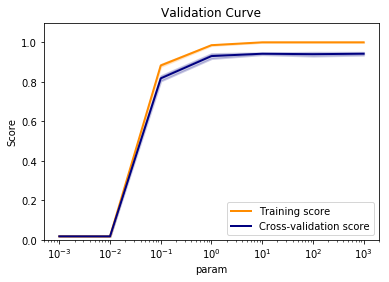

In [55]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [57]:
'''test data'''
est = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000, C=1000)
est.fit(xtrain, np.argmax(ytrain, axis=1))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [59]:
pred = est.predict(xtrain)

In [60]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.00        91

   micro avg       1.00      1.00      1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 93  0  0  0  0  0  0]
 [ 0  0  0  0 88  0  0  0  0  0]
 [ 0  0  0  0  0 91  0  0  0  0]
 [ 0  0  0  0  0  0 90  0  0

In [61]:
pred_test = est.predict(xtest)

In [62]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9633109064024975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       0.94      0.91      0.93        93
           2       0.98      1.00      0.99        86
           3       0.97      0.99      0.98        90
           4       1.00      0.97      0.98        93
           5       0.94      0.98      0.96        91
           6       1.00      0.98      0.99        91
           7       0.97      0.98      0.97        88
           8       0.88      0.91      0.89        88
           9       0.96      0.92      0.94        89

   micro avg       0.96      0.96      0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 85  2  1  0  1  0  0  4  0]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  0 89  0  0  0  0  1  0]
 [ 0  0  0  0 90  0  0  1  0  2]
 [ 0  0  0  0  0 89  0  1  0  1]
 [ 0  0  0  0

## ベンチマーク LGBMClassifier

In [63]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [64]:
param_name = "reg_alpha"
param_range = np.logspace(-3, 3, 7)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [73]:
%%time

train_scores, test_scores = validation_curve(
    LGBMClassifier(
        min_child_samples=20,
        reg_alpha=0.1
    ),
    xtrain, np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] reg_alpha=0.001 .................................................
[CV] .................................. reg_alpha=0.001, total=   0.0s
[CV] reg_alpha=0.01 ..................................................
[CV] ................................... reg_alpha=0.01, total=   0.0s
[CV] reg_alpha=0.1 ...................................................
[CV] .................................... reg_alpha=0.1, total=   0.0s
[CV] reg_alpha=1.0 ...................................................
[CV] .................................... reg_alpha=1.0, total=   0.0s
[CV] reg_alpha=10.0 ..................................................
[CV] ................................... reg_alpha=10.0, total=   0.0s
[CV] reg_alpha=100.0 .................................................
[CV] .................................. reg_alpha=100.0, total=   0.0s
[CV] reg_alpha=1000.0 ................................................
[CV] ................................. reg_alpha=1000.0, total=   0.0s
[CV] r

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.5s finished


In [74]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 9.55956073e-01, 8.54552386e-01],
       [1.00000000e-02, 9.55982579e-01, 8.53570294e-01],
       [1.00000000e-01, 9.54834065e-01, 8.54249974e-01],
       [1.00000000e+00, 9.41107282e-01, 8.56470400e-01],
       [1.00000000e+01, 9.04822161e-01, 8.25580827e-01],
       [1.00000000e+02, 1.78125000e-02, 1.79190751e-02],
       [1.00000000e+03, 1.78125000e-02, 1.79190751e-02]])

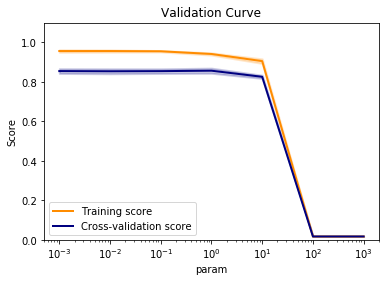

In [75]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [91]:
'''test data'''
est = LGBMClassifier(
        min_child_samples=20,
        reg_alpha=0.1
    )
est.fit(xtrain, np.argmax(ytrain, axis=1))

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=20,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='multiclass', reg_alpha=0.1, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1)

In [92]:
pred = est.predict(xtrain)

In [93]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9590311774708322
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        88
           1       0.91      0.96      0.93        89
           2       0.98      0.99      0.98        91
           3       0.92      0.97      0.94        93
           4       0.99      0.97      0.98        88
           5       0.98      0.95      0.96        91
           6       1.00      0.97      0.98        90
           7       0.95      0.96      0.95        91
           8       0.98      0.94      0.96        86
           9       0.92      0.90      0.91        91

   micro avg       0.96      0.96      0.96       898
   macro avg       0.96      0.96      0.96       898
weighted avg       0.96      0.96      0.96       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 85  0  2  0  1  0  0  0  1]
 [ 0  1 90  0  0  0  0  0  0  0]
 [ 0  1  1 90  0  0  0  1  0  0]
 [ 1  0  0  0 85  0  0  0  1  1]
 [ 0  1  0  0  0 86  0  0  0  4]
 [ 1  2  0  0

In [94]:
pred_test = est.predict(xtest)

In [95]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9003445134291959
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       0.91      0.87      0.89        93
           2       0.90      0.93      0.91        86
           3       0.84      0.87      0.85        90
           4       0.97      0.90      0.93        93
           5       0.87      0.85      0.86        91
           6       0.97      0.92      0.94        91
           7       0.92      0.94      0.93        88
           8       0.90      0.83      0.86        88
           9       0.77      0.89      0.82        89

   micro avg       0.90      0.90      0.90       899
   macro avg       0.90      0.90      0.90       899
weighted avg       0.90      0.90      0.90       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 81  2  6  0  1  0  0  0  3]
 [ 0  0 80  2  0  0  2  0  2  0]
 [ 0  1  1 78  0  2  1  0  2  5]
 [ 1  3  0  0 84  2  0  2  1  0]
 [ 0  1  0  2  1 77  0  1  0  9]
 [ 0  0  1  0

In [6]:
# import copy

# from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
# from keras.optimizers import RMSprop, Adam
# from keras.initializers import glorot_uniform
# from keras.models import Sequential



# def make_model_gkernel1(
#     nn=4, num_lm=2,
#     random_state=None, lm=None, gamma=None):
#     '''
#     just activation
#     '''
#     inp = Input(shape=(nn,), name='inp')
#     oup = inp
    
#     if lm is None:
#         rs = np.random.RandomState(random_state)
#         lm = rs.random_sample((num_lm, nn))
#     if gamma is None:
#         gamma = 1/(2*np.sqrt(nn/6)*2)
#     weights = [np.log(np.array([gamma]))]
#     oup = GaussianKernel2(lm, weights=weights, name='gkernel', trainable=False)(oup)
    
#     model = Model(inp, oup, name='model_gkernel')
#     return lm, model

# def make_model_gkernel2(
#     nn=4, num_lm=2,
#     random_state=None, lm=None, gamma=None):
    
#     inp = Input(shape=(nn,), name='inp')
#     oup = inp
    
#     if lm is None:
#         rs = np.random.RandomState(random_state)
#         lm = rs.random_sample((num_lm, nn))
#     if gamma is None:
#         gamma = 1/(2*np.sqrt(nn/6)*2)
#     weights = [np.log(np.array([gamma]))]
#     #weights = [np.array([gamma])]
#     oup = GaussianKernel2(lm, weights=weights, name='gkernel')(oup)
    
#     model = Model(inp, oup, name='model_gkernel')
#     return lm, model

# def make_model_gkernel3(
#     nn=4, num_lm=2,
#     random_state=None, lm=None, gamma=None):

#     inp = Input(shape=(nn,), name='inp')
#     oup = inp
    
#     if lm is None:
#         rs = np.random.RandomState(random_state)
#         lm = rs.random_sample((num_lm, nn))
#     if gamma is None:
#         gamma = 1/(2*np.sqrt(nn/6)*2)
#     weights = [lm, np.log(np.array([gamma]))]
#     oup = GaussianKernel3(num_landmark=num_lm, num_feature=nn, weights=weights, name='gkernel')(oup)
    
#     model = Model(inp, oup, name='model_gkernel')
#     return lm, model

# def make_model_out(
#     num_lm=2, num_cls=3,
#     activation='softmax',
#     reg_l1=0.0, reg_l2=0.0,
#     random_state=None
# ):
#     inp = Input(shape=(num_lm,), name='inp')
#     oup = Dense(num_cls,
#                 activation=activation,
#                 kernel_initializer=glorot_uniform(random_state),
#                 kernel_regularizer=regularizers.l1_l2(reg_l1, reg_l2),
#                 bias_regularizer=regularizers.l1_l2(reg_l1, reg_l2)
#                )(inp)
    
#     model = Model(inp, oup, name='model_out')
#     return model

# def make_model(
#     make_model_gkernel=make_model_gkernel2,
#     make_model_out=make_model_out,
#     reg_l1=0.0, reg_l2=0.0,
#     nn=2,
#     num_lm=2, lm=None, gamma=None,
#     random_state=None,
#     num_cls=2, activation='softmax',
#     opt=0.02, lr=0.02,
#     loss='categorical_crossentropy',
#     session_clear=True,
#     #gkernel_multipliers=1.0,
#     lm_select_from_x=None,
#     tol=None
# ):
#     if session_clear:
#         K.clear_session()
    
#     lm, model_gkernel = make_model_gkernel(
#         nn=nn, num_lm=num_lm,
#         random_state=random_state, lm=lm, gamma=gamma
#     )
#     model_out = make_model_out(
#         num_lm=num_lm, num_cls=num_cls,
#         activation=activation,
#         reg_l1=reg_l1, reg_l2=reg_l2,
#         random_state=random_state
#     )
#     #model_gkernel.summary()
#     #model_out.summary()
    
#     inp = model_gkernel.inputs[0]
#     oup = model_gkernel(inp)
#     oup = model_out(oup)
    
#     model = Model(inp, oup)
#     #model.summary()
# #     if isinstance(opt, float):
# #         opt = Adam(opt)
# #     learning_rate_multipliers = {
# #         'gkernel': gkernel_multipliers,
# #     }
# #     print(learning_rate_multipliers)
# #     opt = Adam_lr_mult(
# #         lr,
# #         multipliers=learning_rate_multipliers,
# #         debug_verbose=False)
#     opt = Adam(lr)
#     model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
#     return model


# class RBFBase(object):
    
#     def _fit(self, x, y, sample_weight=None, **kwargs):
#         sk_params_org = copy.deepcopy(self.sk_params)
        
#         ### nn
#         nn = x.shape[1]
#         sk_params_org.update({'nn': self.sk_params.get('nn')})
#         self.set_params(nn=nn)
        
#         ### learning_rate
#         if self.sk_params.get('lr') is None:
#             lr = 0.02 # default lr
#             sk_params_org.update({'lr': None})
#             self.set_params(lr=lr)
#         else:
#             lr = self.sk_params['lr'] # for later using
        
#         ### gamma
#         if self.sk_params.get('gamma') == 'scale':
#             sk_params_org.update({'gamma': 'scale'})
#             self.set_params(gamma=1 / (nn * x.var()))
#             #print('scale gamma >', self.sk_params['gamma'])
        
#         ### tol
#         tol = self.sk_params.get('tol', np.finfo(np.float32).eps)
        
#         ### callbacks
#         if self.sk_params.get('callbacks', None) is None:
#             lr_reducer = ReduceLROnPlateau(monitor='loss', 
#                                factor=1/2,
#                                verbose=0,
#                                cooldown=7,
#                                patience=5,
#                                min_lr=lr/64/2)
#             #tol = np.sqrt(np.finfo(np.float32).eps)
#             #tol = np.finfo(np.float32).eps
#             #tol = 0.0
#             early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta=tol, restore_best_weights=True)
#             callbacks0 = [lr_reducer, early_stopping]
#             callbacks = [lr_reducer, early_stopping]
#             sk_params_org.update({'callbacks': None})
#             self.set_params(callbacks=callbacks)
#         else:
#             callbacks0 = self.sk_params['callbacks']
#             callbacks = self.sk_params['callbacks']
        
#         ### lm_select_from_x
#         #print('''self.sk_params.get('lm_select_from_x') >''', self.sk_params.get('lm_select_from_x'))
#         if self.sk_params.get('lm_select_from_x'):
#             random_state = self.sk_params.get('random_state')
#             rs = np.random.RandomState(random_state)
#             lm = x[rs.choice(np.arange(x.shape[0]), self.sk_params['num_lm'], replace=False)]
#             sk_params_org.update({'lm': self.sk_params.get('lm')})
#             self.set_params(lm=lm)
        
#         hst = super().fit(x, y, **kwargs)
        
#         fit_args = copy.deepcopy(self.filter_sk_params(Sequential.fit))
#         fit_args.update(kwargs)
        
#         def lr_schedule2(epoch):
#             lr1 = lr / 2
#             #print('lr >', lr1)
#             return lr1
#         def lr_schedule4(epoch):
#             lr1 = lr / 4
#             #print('lr >', lr1)
#             return lr1
#         def lr_schedule8(epoch):
#             lr1 = lr / 8
#             #print('lr >', lr1)
#             return lr1
        
#         # 2
#         lr_scheduler = LearningRateScheduler(lr_schedule2)
#         callbacks = callbacks0 + [lr_scheduler]
#         fit_args['callbacks'] = callbacks
#         hst = self.model.fit(x, y, **fit_args)
#         # 3
#         lr_scheduler = LearningRateScheduler(lr_schedule4)
#         callbacks = callbacks0 + [lr_scheduler]
#         fit_args['callbacks'] = callbacks
#         hst = self.model.fit(x, y, **fit_args)
#         # 4
#         lr_scheduler = LearningRateScheduler(lr_schedule8)
#         callbacks = callbacks0 + [lr_scheduler]
#         fit_args['callbacks'] = callbacks
#         hst = self.model.fit(x, y, **fit_args)
        
#         # 2
#         lr_scheduler = LearningRateScheduler(lr_schedule2)
#         callbacks = callbacks0 + [lr_scheduler]
#         fit_args['callbacks'] = callbacks
#         hst = self.model.fit(x, y, **fit_args)
#         # 3
#         lr_scheduler = LearningRateScheduler(lr_schedule4)
#         callbacks = callbacks0 + [lr_scheduler]
#         fit_args['callbacks'] = callbacks
#         hst = self.model.fit(x, y, **fit_args)
#         # 4
#         lr_scheduler = LearningRateScheduler(lr_schedule8)
#         callbacks = callbacks0 + [lr_scheduler]
#         fit_args['callbacks'] = callbacks
#         hst = self.model.fit(x, y, **fit_args)
        
#         #print(self.sk_params)
#         #print(sk_params_org)
#         self.set_params(**sk_params_org)
#         #print(self.sk_params)
#         return hst
    
#     def current_gamma(self):
#         for ew in self.model.layers[1].layers[1].get_weights():
#             if len(ew.shape)==1:
#                 c_gamma = ew[0]
#         return np.exp(c_gamma)


# class RBFClassifier(RBFBase, KerasClassifier):
    
#     def __init__(self, build_fn=make_model, **sk_params):
#         super().__init__(build_fn, **sk_params)
    
#     def fit(self, x, y, sample_weight=None, **kwargs):
#         ### num_cls
#         self.set_params(num_cls=self.sk_params.get('num_cls', y.shape[1]))
#         hst = super()._fit(x, y, sample_weight=None, **kwargs)
#         return hst

# class RBFRegressor(RBFBase, KerasRegressor):
    
#     def __init__(self, build_fn=make_model, **sk_params):
#         super().__init__(build_fn, **sk_params)
    
#     def fit(self, x, y, sample_weight=None, **kwargs):
#         ### num_cls
#         self.set_params(num_cls=self.sk_params.get('num_cls', 1))
        
#         ### activation
#         self.set_params(activation=self.sk_params.get('activation', 'linear'))
        
#         ### loss
#         self.set_params(loss=self.sk_params.get('loss', 'mse'))
        
#         hst = super()._fit(x, y, sample_weight=None, **kwargs)
#         return hst

In [7]:
#clf = RBFClassifier(num_lm=3)
# clf = RBFClassifier(
#     num_lm=3,
#     lm=xtrain[:3]
# )
# clf = RBFClassifier(
#     num_lm=50,
#     lm=xtrain[:50],
#     make_model_gkernel=make_model_gkernel3
# )
# early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta=0.000, restore_best_weights=True)
# clf = RBFClassifier(
#     num_lm=3,
#     lm=xtrain[np.random.choice(np.arange(xtrain.shape[0]), 3)],
# )
# clf = RBFClassifier(
#     num_lm=10,
#     lm=xtrain[:10],
#     callbacks=[early_stopping],
#     make_model_gkernel=make_model_gkernel3
# )
# clf = RBFClassifier(
#     num_lm=3,
#     lm=xtrain[:3],
#     make_model_gkernel=make_model_gkernel3,
#     activation='sigmoid',
#     loss='binary_crossentropy'
# )
clf = RBFClassifier(
    num_lm=10,
    lm=xtrain[np.random.choice(np.arange(xtrain.shape[0]), 10)],
    reg_l1=0.00,
    lr=0.02,
    random_state=101
)
clf

In [8]:
%%time
clf.fit(xtrain, ytrain, epochs=500, batch_size=1024, verbose=0)

W0923 23:44:19.782620 140690256598848 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0923 23:44:19.785177 140690256598848 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0923 23:44:19.796476 140690256598848 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0923 23:44:19.797162 140690256598848 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: T

CPU times: user 17.5 s, sys: 590 ms, total: 18.1 s
Wall time: 12.6 s


In [9]:
clf.sk_params

{'callbacks': None,
 'lm': array([[0.    , 0.    , 0.1875, 0.75  , 0.9375, 0.6875, 0.125 , 0.    ,
         0.    , 0.    , 0.6875, 0.8125, 0.4375, 0.8125, 0.5   , 0.    ,
         0.    , 0.4375, 0.9375, 0.0625, 0.3125, 0.9375, 0.1875, 0.    ,
         0.    , 0.0625, 0.75  , 1.    , 1.    , 0.3125, 0.    , 0.    ,
         0.    , 0.    , 0.    , 0.8125, 0.9375, 0.9375, 0.125 , 0.    ,
         0.    , 0.    , 0.125 , 0.8125, 0.    , 0.625 , 0.3125, 0.    ,
         0.    , 0.    , 0.25  , 0.6875, 0.25  , 0.6875, 0.375 , 0.    ,
         0.    , 0.    , 0.125 , 0.8125, 1.    , 0.75  , 0.    , 0.    ],
        [0.    , 0.    , 0.3125, 0.9375, 0.4375, 0.    , 0.    , 0.    ,
         0.    , 0.    , 0.875 , 1.    , 1.    , 0.3125, 0.    , 0.    ,
         0.    , 0.    , 0.8125, 0.875 , 0.875 , 0.9375, 0.    , 0.    ,
         0.    , 0.    , 0.1875, 0.6875, 0.875 , 1.    , 0.1875, 0.    ,
         0.    , 0.    , 0.    , 0.    , 0.375 , 1.    , 0.125 , 0.    ,
         0.    , 0.    ,

In [10]:
clf.__dict__

{'build_fn': <function gkernel.sklearn.make_model>,
 'classes_': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'model': <keras.engine.training.Model at 0x7ff4ae9cb898>,
 'n_classes_': 10,
 'sk_params': {'callbacks': None,
  'lm': array([[0.    , 0.    , 0.1875, 0.75  , 0.9375, 0.6875, 0.125 , 0.    ,
          0.    , 0.    , 0.6875, 0.8125, 0.4375, 0.8125, 0.5   , 0.    ,
          0.    , 0.4375, 0.9375, 0.0625, 0.3125, 0.9375, 0.1875, 0.    ,
          0.    , 0.0625, 0.75  , 1.    , 1.    , 0.3125, 0.    , 0.    ,
          0.    , 0.    , 0.    , 0.8125, 0.9375, 0.9375, 0.125 , 0.    ,
          0.    , 0.    , 0.125 , 0.8125, 0.    , 0.625 , 0.3125, 0.    ,
          0.    , 0.    , 0.25  , 0.6875, 0.25  , 0.6875, 0.375 , 0.    ,
          0.    , 0.    , 0.125 , 0.8125, 1.    , 0.75  , 0.    , 0.    ],
         [0.    , 0.    , 0.3125, 0.9375, 0.4375, 0.    , 0.    , 0.    ,
          0.    , 0.    , 0.875 , 1.    , 1.    , 0.3125, 0.    , 0.    ,
          0.    , 0.    , 0.8125, 0.8

In [11]:
clf.current_gamma()

0.11427088

In [12]:
clf.predict(xtrain)[:10]

array([1, 3, 9, 7, 9, 1, 3, 5, 7, 1])

In [13]:
clf.predict_proba(xtest)[:5]

array([[9.24190164e-01, 1.42645047e-04, 5.75913989e-04, 1.50571548e-04,
        1.44329737e-03, 2.99103837e-02, 1.16840657e-03, 3.04540823e-04,
        2.29085907e-02, 1.92053895e-02],
       [8.69081449e-03, 4.71826971e-01, 2.45093137e-01, 4.95541748e-03,
        4.26684767e-02, 2.19757911e-02, 6.00259006e-02, 1.60581637e-02,
        1.22767545e-01, 5.93775697e-03],
       [2.63670292e-02, 1.08059786e-01, 9.55783413e-04, 2.99776566e-05,
        8.40935111e-01, 1.59446197e-03, 9.59259830e-03, 9.84997302e-03,
        5.24596893e-04, 2.09072116e-03],
       [2.58982200e-02, 1.87338889e-01, 1.46568129e-02, 2.60843808e-04,
        5.11527285e-02, 2.96568405e-02, 6.30047977e-01, 4.53077839e-04,
        5.39223216e-02, 6.61234511e-03],
       [1.61991298e-01, 1.46336318e-03, 6.00928580e-03, 2.72217859e-03,
        5.05853619e-04, 1.20629249e-02, 2.60793362e-02, 9.98455798e-05,
        6.71686947e-01, 1.17379002e-01]], dtype=float32)

In [14]:
clf.score(xtrain, ytrain)

898/898 [==============================] - 0s 144us/step


0.8262806236080178

In [15]:
clf.score(xtest, yans)

899/899 [==============================] - 0s 25us/step


0.8453837597993378

In [16]:
print('F1_SCORE :', f1_score(np.argmax(ytrain,axis=1), clf.predict(xtrain), average='macro'))
print(classification_report(np.argmax(ytrain,axis=1), clf.predict(xtrain)))
print(confusion_matrix(np.argmax(ytrain,axis=1), clf.predict(xtrain)))

F1_SCORE : 0.8248791607415862
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        88
           1       0.76      0.73      0.75        89
           2       0.87      0.79      0.83        91
           3       0.86      0.87      0.87        93
           4       0.85      0.95      0.90        88
           5       0.76      0.84      0.80        91
           6       0.87      0.91      0.89        90
           7       0.88      0.89      0.89        91
           8       0.70      0.66      0.68        86
           9       0.76      0.71      0.73        91

   micro avg       0.83      0.83      0.83       898
   macro avg       0.83      0.83      0.82       898
weighted avg       0.83      0.83      0.83       898

[[79  1  0  0  2  5  1  0  0  0]
 [ 0 65  6  0  4  1  2  3  1  7]
 [ 0  4 72  3  1  2  2  2  5  0]
 [ 1  0  1 81  0  1  0  3  3  3]
 [ 0  1  0  0 84  0  0  2  1  0]
 [ 1  3  1  0  0 76  2  0  4  4]
 [ 0  4  0  0

In [17]:
print('F1_SCORE :', f1_score(np.argmax(yans,axis=1), clf.predict(xtest), average='macro'))
print(classification_report(np.argmax(yans,axis=1), clf.predict(xtest)))
print(confusion_matrix(np.argmax(yans,axis=1), clf.predict(xtest)))

F1_SCORE : 0.8450998576273658
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        90
           1       0.77      0.80      0.78        93
           2       0.93      0.90      0.91        86
           3       0.81      0.88      0.84        90
           4       0.90      0.91      0.91        93
           5       0.80      0.78      0.79        91
           6       0.90      0.91      0.91        91
           7       0.89      0.91      0.90        88
           8       0.76      0.72      0.74        88
           9       0.72      0.71      0.72        89

   micro avg       0.85      0.85      0.85       899
   macro avg       0.85      0.85      0.85       899
weighted avg       0.85      0.85      0.85       899

[[85  0  0  0  0  2  2  0  1  0]
 [ 1 74  4  0  4  1  4  0  3  2]
 [ 0  3 77  1  0  0  0  1  4  0]
 [ 0  0  1 79  0  1  0  3  1  5]
 [ 0  2  0  0 85  1  0  4  1  0]
 [ 1  2  0  1  1 71  1  0  3 11]
 [ 1  4  0  0

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, Lasso
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import joblib

In [19]:
%%time

ins_splitter = StratifiedShuffleSplit(n_splits=50, test_size=0.5, random_state=0)
var_idx_all = np.arange(xtrain.shape[1])
#threshold = 0.85
threshold = 0.30
importances = np.zeros((xtrain.shape[1],))
predictions = pd.DataFrame()
#preds_all = pd.DataFrame()
pred_all_list = []
pred_train_all_list = []
counter = 0
np.random.seed(10001)

print("counter  | val_f1    |  val_r2    ")
print("---------------------------------------------")


for train_index, val_index in ins_splitter.split(xtrain, ytrain):
    x_train_tr, x_train_val = xtrain[train_index], xtrain[val_index]
    y_train_tr, y_train_val = ytrain[train_index], ytrain[val_index]
    
    
    #estimator = LGBMRegressor(min_child_samples=50, reg_alpha=100)
    estimator = RBFClassifier(
        num_lm=2,
        lm_select_from_x=True,
        random_state=None,
        lr=0.02, gamma='scale',
        epochs=500, batch_size=1024, verbose=0
    )
    estimator.fit(x_train_tr, y_train_tr)
    
    # score our fitted model on validation data
    val_y_pred = estimator.predict(x_train_val)
    val_mse = mean_squared_error(np.argmax(y_train_val,axis=1), val_y_pred)
    val_mae = mean_absolute_error(np.argmax(y_train_val,axis=1), val_y_pred)
    val_kappa = 0.0
    val_f1 = f1_score(np.argmax(y_train_val,axis=1), val_y_pred, average='macro')
    val_cos = cosine_similarity(np.argmax(y_train_val,axis=1).reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_dst = euclidean_distances(np.argmax(y_train_val,axis=1).reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_r2  = r2_score(np.argmax(y_train_val,axis=1), val_y_pred)
    gamma = estimator.current_gamma()
    
    if val_f1 > threshold:
        message = '<-- OK'
        pred_train_all = estimator.predict_proba(xtrain)
        pred_train_all_list.append(pred_train_all)
        pred_all = estimator.predict_proba(xtest)
        pred_all_list.append(pred_all)
        #preds_all = pd.concat([preds_all, pd.DataFrame(pred_all)], axis=1)
        #prediction = grid_search.best_estimator_.predict(x_test0)
        #predictions = pd.concat([predictions, pd.DataFrame(prediction)], axis=1)
        #importances += estimator.feature_importances_
        #filename = 'model-{}.sav'.format(counter)
        #joblib.dump(estimator, filename)
    else:
        message = '<-- skipping'

    print("{0:5}    |  {3:.4f}   |  {4:.4f}   {5:5e} {7}  ".format(
        counter,
        val_mse,
        val_mae,
        val_f1,
        val_r2,
        gamma,
        0,
        message))
    
    counter += 1

counter  | val_f1    |  val_r2    
---------------------------------------------
    0    |  0.4204   |  -0.6106   1.235459e-01 <-- OK  
    1    |  0.4088   |  -0.4615   1.182230e-01 <-- OK  
    2    |  0.4203   |  -0.6536   1.144033e-01 <-- OK  


/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


    3    |  0.4060   |  -0.1983   1.103966e-01 <-- OK  
    4    |  0.3204   |  -0.1793   1.206005e-01 <-- OK  
    5    |  0.3872   |  -0.3883   1.433272e-01 <-- OK  
    6    |  0.4030   |  -0.1596   1.009572e-01 <-- OK  
    7    |  0.3930   |  -0.3983   1.222785e-01 <-- OK  
    8    |  0.4056   |  -0.3601   1.385151e-01 <-- OK  
    9    |  0.3152   |  -0.6620   1.058504e-01 <-- OK  
   10    |  0.3768   |  -0.2431   1.353818e-01 <-- OK  
   11    |  0.3448   |  -0.5477   1.331684e-01 <-- OK  
   12    |  0.4403   |  -0.3226   1.129881e-01 <-- OK  
   13    |  0.3788   |  -0.2013   1.025722e-01 <-- OK  
   14    |  0.4283   |  -0.5616   1.377715e-01 <-- OK  
   15    |  0.3029   |  -0.5757   8.906122e-02 <-- OK  
   16    |  0.3731   |  -0.1813   1.065135e-01 <-- OK  
   17    |  0.3541   |  -0.6318   1.498295e-01 <-- OK  
   18    |  0.4011   |  -0.3450   1.099304e-01 <-- OK  
   19    |  0.4713   |  -0.1160   1.080779e-01 <-- OK  
   20    |  0.4403   |  -0.3110   1.219129e-01 <

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


   26    |  0.2669   |  -0.6829   1.491105e-01 <-- skipping  
   27    |  0.3932   |  -0.3414   1.126856e-01 <-- OK  
   28    |  0.4488   |  -0.0592   1.300201e-01 <-- OK  
   29    |  0.4271   |  -0.0990   1.296547e-01 <-- OK  
   30    |  0.5106   |  0.1255   1.257863e-01 <-- OK  
   31    |  0.3827   |  -0.4586   1.447242e-01 <-- OK  
   32    |  0.4013   |  -0.0531   9.644230e-02 <-- OK  
   33    |  0.3848   |  -0.4468   1.133118e-01 <-- OK  
   34    |  0.4135   |  -0.6089   1.059621e-01 <-- OK  
   35    |  0.4821   |  0.0972   1.196165e-01 <-- OK  
   36    |  0.3906   |  -0.3569   1.422569e-01 <-- OK  
   37    |  0.3753   |  -0.3227   1.238176e-01 <-- OK  
   38    |  0.3598   |  -0.3098   9.428260e-02 <-- OK  
   39    |  0.3225   |  -0.6177   9.484406e-02 <-- OK  
   40    |  0.4030   |  -0.2968   1.222501e-01 <-- OK  
   41    |  0.3359   |  -0.5366   1.240893e-01 <-- OK  
   42    |  0.3869   |  -0.4119   1.177511e-01 <-- OK  
   43    |  0.3588   |  -0.6153   1.233508e-

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


   45    |  0.3813   |  -0.2248   1.231836e-01 <-- OK  
   46    |  0.3647   |  -0.3749   1.284760e-01 <-- OK  
   47    |  0.3845   |  -0.7125   1.313143e-01 <-- OK  
   48    |  0.3871   |  -0.5191   1.506562e-01 <-- OK  
   49    |  0.4854   |  0.0609   1.263022e-01 <-- OK  
CPU times: user 12min 5s, sys: 22.9 s, total: 12min 27s
Wall time: 8min 46s


In [20]:
for ee in pred_train_all_list:
    print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), np.argmax(ee, axis=1), average='macro'))

F1_SCORE : 0.4406541654186345
F1_SCORE : 0.40382556210984094
F1_SCORE : 0.4289029587954074
F1_SCORE : 0.37143901258116674
F1_SCORE : 0.3451013460337898
F1_SCORE : 0.3781137288610215
F1_SCORE : 0.41809227501234536
F1_SCORE : 0.4109717799143865
F1_SCORE : 0.4156301865411013
F1_SCORE : 0.31348167485810374
F1_SCORE : 0.4035436519207666
F1_SCORE : 0.36313971959248087
F1_SCORE : 0.44060550260464987
F1_SCORE : 0.3757763654354628
F1_SCORE : 0.4300674638790711
F1_SCORE : 0.3157810695123784
F1_SCORE : 0.3897017805204272
F1_SCORE : 0.36422907916676855
F1_SCORE : 0.39088406487111904
F1_SCORE : 0.4727710350961768
F1_SCORE : 0.4369394420024625
F1_SCORE : 0.46231307745810446
F1_SCORE : 0.40456716817038085
F1_SCORE : 0.3463540985484071
F1_SCORE : 0.42277340326467006
F1_SCORE : 0.42101145251645294
F1_SCORE : 0.3987467168035996
F1_SCORE : 0.46502425312257606
F1_SCORE : 0.4268926394578427
F1_SCORE : 0.5129131457314077
F1_SCORE : 0.3759248399832348
F1_SCORE : 0.4259226081912919
F1_SCORE : 0.37681334800261

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), np.argmax(np.stack(pred_train_all_list).mean(axis=0), axis=1), average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), np.argmax(np.stack(pred_train_all_list).mean(axis=0), axis=1)))
print(confusion_matrix(np.argmax(ytrain, axis=1), np.argmax(np.stack(pred_train_all_list).mean(axis=0), axis=1)))

F1_SCORE : 0.8645262684606015
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        88
           1       0.89      0.85      0.87        89
           2       0.87      0.82      0.85        91
           3       0.81      0.87      0.84        93
           4       0.83      0.97      0.89        88
           5       0.92      0.76      0.83        91
           6       0.97      0.99      0.98        90
           7       0.82      0.98      0.89        91
           8       0.91      0.71      0.80        86
           9       0.70      0.75      0.72        91

   micro avg       0.87      0.87      0.87       898
   macro avg       0.87      0.87      0.86       898
weighted avg       0.87      0.87      0.86       898

[[84  0  0  0  2  0  2  0  0  0]
 [ 0 76  5  0  1  0  1  0  0  6]
 [ 1  1 75  6  3  0  0  2  3  0]
 [ 0  0  2 81  0  1  0  4  0  5]
 [ 0  0  0  0 85  0  0  3  0  0]
 [ 1  0  0  3  2 69  0  3  2 11]
 [ 0  1  0  0

In [22]:
np.stack(pred_all_list).mean(axis=0).shape

(899, 10)

In [23]:
for ee in pred_all_list:
    print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), np.argmax(ee, axis=1), average='macro'))

F1_SCORE : 0.44997031015879624
F1_SCORE : 0.4243263455121663
F1_SCORE : 0.41583134051168774
F1_SCORE : 0.3692130605959628
F1_SCORE : 0.3314889111615035
F1_SCORE : 0.3933025556137534
F1_SCORE : 0.3886387882885815
F1_SCORE : 0.40810043902014803
F1_SCORE : 0.43286137595582935
F1_SCORE : 0.32195295574428734
F1_SCORE : 0.4044382641315557
F1_SCORE : 0.3707030017908365
F1_SCORE : 0.4522835489079161
F1_SCORE : 0.37072128318755276
F1_SCORE : 0.46361398312893504
F1_SCORE : 0.35038227452794773
F1_SCORE : 0.42130516306406296
F1_SCORE : 0.3744701164078785
F1_SCORE : 0.40153766865750595
F1_SCORE : 0.49975508481551423
F1_SCORE : 0.3882238773082986
F1_SCORE : 0.455455067162578
F1_SCORE : 0.3795611399600135
F1_SCORE : 0.39961149526832884
F1_SCORE : 0.35834112910698396
F1_SCORE : 0.4212040734016905
F1_SCORE : 0.3976923810296032
F1_SCORE : 0.45604738390351585
F1_SCORE : 0.43695179831241837
F1_SCORE : 0.5111000756557869
F1_SCORE : 0.3572610929181027
F1_SCORE : 0.41396458024183946
F1_SCORE : 0.350517231643

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), np.argmax(np.stack(pred_all_list).mean(axis=0), axis=1), average='macro'))
print(classification_report(np.argmax(yans, axis=1), np.argmax(np.stack(pred_all_list).mean(axis=0), axis=1)))
print(confusion_matrix(np.argmax(yans, axis=1), np.argmax(np.stack(pred_all_list).mean(axis=0), axis=1)))

F1_SCORE : 0.8826660371568613
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       0.88      0.78      0.83        93
           2       0.87      0.88      0.88        86
           3       0.87      0.86      0.86        90
           4       0.91      0.92      0.92        93
           5       0.95      0.76      0.84        91
           6       0.95      0.99      0.97        91
           7       0.82      0.98      0.89        88
           8       0.89      0.84      0.87        88
           9       0.73      0.82      0.77        89

   micro avg       0.88      0.88      0.88       899
   macro avg       0.89      0.88      0.88       899
weighted avg       0.89      0.88      0.88       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 73  7  0  3  0  5  0  0  5]
 [ 0  2 76  2  1  0  0  0  3  2]
 [ 0  0  1 77  0  0  0  4  5  3]
 [ 0  1  0  0 86  0  0  6  0  0]
 [ 0  0  0  3  2 69  0  2  1 14]
 [ 0  0  0  0

## validation_curve + LogisticRegression

In [25]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [26]:
param_name = "C"
param_range = np.logspace(-3, 3, 7)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [27]:
def f1_scorer(estimator, X, y):
    pred = estimator.predict(X)
    s = f1_score(y, pred, average='macro')
    return s

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
%%time

train_scores, test_scores = validation_curve(
    LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000),
    np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   3.2s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   9.4s
[CV] C=10.0 ..........................................................
[CV] ........................................... C=10.0, total=  41.6s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total= 1.2min
[CV] C=1000.0 ........................................................
[CV] ......................................... C=1000.0, total= 1.1min
[CV] C

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  9.7min finished


In [30]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 1.83800623e-02, 1.82688944e-02],
       [1.00000000e-02, 1.81908749e-02, 1.82688944e-02],
       [1.00000000e-01, 8.82685922e-01, 8.51054622e-01],
       [1.00000000e+00, 9.65075150e-01, 9.00063108e-01],
       [1.00000000e+01, 1.00000000e+00, 9.36120626e-01],
       [1.00000000e+02, 1.00000000e+00, 9.47683157e-01],
       [1.00000000e+03, 1.00000000e+00, 9.49787209e-01]])

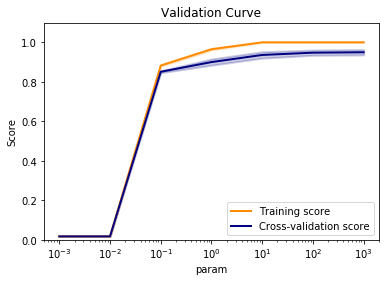

In [31]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [32]:
'''test data'''
est = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000, C=1000)
est.fit(np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
pred = est.predict(np.hstack(pred_train_all_list))

In [34]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.00        91

   micro avg       1.00      1.00      1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 93  0  0  0  0  0  0]
 [ 0  0  0  0 88  0  0  0  0  0]
 [ 0  0  0  0  0 91  0  0  0  0]
 [ 0  0  0  0  0  0 90  0  0

In [35]:
pred_test = est.predict(np.hstack(pred_all_list))

In [36]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9699530110220188
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        90
           1       0.97      0.96      0.96        93
           2       0.99      1.00      0.99        86
           3       0.95      0.98      0.96        90
           4       0.99      0.99      0.99        93
           5       0.98      0.95      0.96        91
           6       1.00      0.98      0.99        91
           7       0.97      0.98      0.97        88
           8       0.94      0.94      0.94        88
           9       0.93      0.94      0.94        89

   micro avg       0.97      0.97      0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899

[[89  0  1  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  1  0  0  2  1]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  0 88  0  0  0  1  1  0]
 [ 0  0  0  0 92  0  0  1  0  0]
 [ 0  0  0  1  1 86  0  0  1  2]
 [ 1  0  0  0

## validation_curve + LGBMClassifier

In [37]:
'''LGBMClassifier'''
from lightgbm import LGBMClassifier

param_name = "reg_alpha"
param_range = np.logspace(-3, 3, 7)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [38]:
%%time

train_scores, test_scores = validation_curve(
    LGBMClassifier(
        min_child_samples=50,
        reg_alpha=0.1
    ),
    np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] reg_alpha=0.001 .................................................
[CV] .................................. reg_alpha=0.001, total=   0.3s
[CV] reg_alpha=0.01 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ................................... reg_alpha=0.01, total=   0.3s
[CV] reg_alpha=0.1 ...................................................
[CV] .................................... reg_alpha=0.1, total=   0.3s
[CV] reg_alpha=1.0 ...................................................
[CV] .................................... reg_alpha=1.0, total=   0.2s
[CV] reg_alpha=10.0 ..................................................
[CV] ................................... reg_alpha=10.0, total=   0.2s
[CV] reg_alpha=100.0 .................................................
[CV] .................................. reg_alpha=100.0, total=   0.1s
[CV] reg_alpha=1000.0 ................................................
[CV] ................................. reg_alpha=1000.0, total=   0.1s
[CV] reg_alpha=0.001 .................................................
[CV] .................................. reg_alpha=0.001, total=   0.3s
[CV] reg_alpha=0.01 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.4s finished


In [39]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 9.50422580e-01, 8.66096647e-01],
       [1.00000000e-02, 9.51001885e-01, 8.65083273e-01],
       [1.00000000e-01, 9.50409128e-01, 8.65083273e-01],
       [1.00000000e+00, 9.52720781e-01, 8.58514058e-01],
       [1.00000000e+01, 9.32318695e-01, 8.53500481e-01],
       [1.00000000e+02, 1.78125000e-02, 1.79190751e-02],
       [1.00000000e+03, 1.78125000e-02, 1.79190751e-02]])

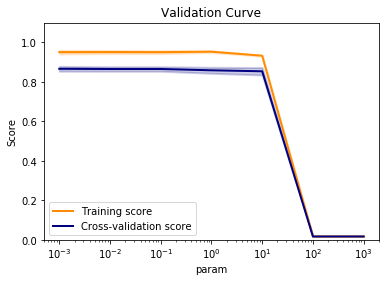

In [40]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [41]:
'''test data'''
est = LGBMClassifier(
        min_child_samples=50,
        reg_alpha=0.01
    )
est.fit(np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1))

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=50,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='multiclass', reg_alpha=0.01,
        reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

In [42]:
pred = est.predict(np.hstack(pred_train_all_list))

In [43]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9587593096847016
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        88
           1       0.94      0.98      0.96        89
           2       0.97      0.97      0.97        91
           3       0.99      0.92      0.96        93
           4       0.99      0.98      0.98        88
           5       0.95      0.96      0.95        91
           6       0.94      0.99      0.96        90
           7       0.93      0.99      0.96        91
           8       0.95      0.91      0.93        86
           9       0.96      0.93      0.94        91

   micro avg       0.96      0.96      0.96       898
   macro avg       0.96      0.96      0.96       898
weighted avg       0.96      0.96      0.96       898

[[85  0  0  0  1  0  2  0  0  0]
 [ 0 87  0  0  0  0  2  0  0  0]
 [ 0  0 88  1  0  0  0  1  1  0]
 [ 0  0  1 86  0  2  0  1  1  2]
 [ 0  0  0  0 86  0  0  2  0  0]
 [ 0  0  1  0  0 87  1  0  0  2]
 [ 0  1  0  0

In [44]:
pred_test = est.predict(np.hstack(pred_all_list))

In [45]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9206284167301575
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        90
           1       0.92      0.83      0.87        93
           2       0.89      0.94      0.92        86
           3       0.92      0.88      0.90        90
           4       0.98      0.95      0.96        93
           5       0.93      0.92      0.93        91
           6       0.92      0.98      0.95        91
           7       0.91      0.95      0.93        88
           8       0.90      0.91      0.90        88
           9       0.86      0.87      0.86        89

   micro avg       0.92      0.92      0.92       899
   macro avg       0.92      0.92      0.92       899
weighted avg       0.92      0.92      0.92       899

[[89  0  1  0  0  0  0  0  0  0]
 [ 0 77  5  2  0  0  7  0  1  1]
 [ 0  1 81  0  0  0  0  1  3  0]
 [ 0  0  2 79  0  1  0  2  2  4]
 [ 0  0  0  0 88  0  0  3  2  0]
 [ 0  1  1  0  1 84  0  0  0  4]
 [ 1  0  0  0

In [109]:
class RFECV_wr(RFECV):
    
    def __init__(self, C=1.0,
                       step=1, min_features_to_select=1, cv='warn',
                       scoring=None, verbose=0, n_jobs=None):
        estimator = LogisticRegression(
            penalty='l1',
            C=100,
            multi_class='multinomial',
            solver='saga',
            max_iter=10000)
        super().__init__(estimator, step=step,
                         min_features_to_select=min_features_to_select,
                         cv=cv, scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    
    def set_params(self, **params):
        if 'C' in params:
            self.estimator.set_params(C=params['C'])
        return self

feature_selector = RFECV_wr(min_features_to_select=5,
                             scoring=f1_scorer,
                             step=15,
                             verbose=0,
                             cv=20,
                             n_jobs=1)

In [110]:
%%time

train_scores, test_scores = validation_curve(
    feature_selector,
    np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=-1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   2.3s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=  12.8s
[CV] C=10.0 ..........................................................
[CV] ........................................... C=10.0, total= 2.1min
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total= 4.6min
[CV] C=1000.0 ........................................................
[CV] ......................................... C=1000.0, total= 7.0min
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 39.3min finished


In [111]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 1.80008020e-02, 1.80919656e-02],
       [1.00000000e-02, 1.81908749e-02, 1.82688944e-02],
       [1.00000000e-01, 5.43982236e-01, 5.14956913e-01],
       [1.00000000e+00, 8.31884603e-01, 7.80136116e-01],
       [1.00000000e+01, 9.66674265e-01, 8.75295491e-01],
       [1.00000000e+02, 9.98288982e-01, 8.78200716e-01],
       [1.00000000e+03, 1.00000000e+00, 8.77806123e-01]])

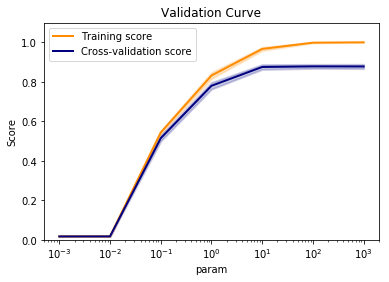

In [112]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [ ]:
%%time
'''RFE'''

param_grid = {
            'C' : param_range,
        }

ins_splitter = StratifiedShuffleSplit(n_splits=100, test_size=0.5, random_state=0)
var_idx_all = np.arange(xtrain.shape[1])
#threshold = 0.85
threshold = 0.30
importances = np.zeros((xtrain.shape[1],))
predictions = pd.DataFrame()
#preds_all = pd.DataFrame()
pred_all_list = []
pred_train_all_list = []
counter = 0
np.random.seed(10001)

feature_selector = RFECV()


print("counter  | val_f1    |  val_r2    ")
print("---------------------------------------------")

for train_index, val_index in ins_splitter.split(xtrain, ytrain):
    x_train_tr, x_train_val = xtrain[train_index], xtrain[val_index]
    y_train_tr, y_train_val = ytrain[train_index], ytrain[val_index]
    
    
    #estimator = LGBMRegressor(min_child_samples=50, reg_alpha=100)
    estimator = RBFClassifier(
        num_lm=2,
        lm_select_from_x=True,
        random_state=None,
        lr=0.02, gamma='scale',
        epochs=500, batch_size=1024, verbose=0
    )
    estimator.fit(x_train_tr, y_train_tr)
    
    # score our fitted model on validation data
    val_y_pred = estimator.predict(x_train_val)
    val_mse = mean_squared_error(np.argmax(y_train_val,axis=1), val_y_pred)
    val_mae = mean_absolute_error(np.argmax(y_train_val,axis=1), val_y_pred)
    val_kappa = 0.0
    val_f1 = f1_score(np.argmax(y_train_val,axis=1), val_y_pred, average='macro')
    val_cos = cosine_similarity(np.argmax(y_train_val,axis=1).reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_dst = euclidean_distances(np.argmax(y_train_val,axis=1).reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_r2  = r2_score(np.argmax(y_train_val,axis=1), val_y_pred)
    gamma = estimator.current_gamma()
    
    if val_f1 > threshold:
        message = '<-- OK'
        pred_train_all = estimator.predict_proba(xtrain)
        pred_train_all_list.append(pred_train_all)
        pred_all = estimator.predict_proba(xtest)
        pred_all_list.append(pred_all)
        #preds_all = pd.concat([preds_all, pd.DataFrame(pred_all)], axis=1)
        #prediction = grid_search.best_estimator_.predict(x_test0)
        #predictions = pd.concat([predictions, pd.DataFrame(prediction)], axis=1)
        #importances += estimator.feature_importances_
        #filename = 'model-{}.sav'.format(counter)
        #joblib.dump(estimator, filename)
    else:
        message = '<-- skipping'

    print("{0:5}    |  {3:.4f}   |  {4:.4f}   {5:5e} {7}  ".format(
        counter,
        val_mse,
        val_mae,
        val_f1,
        val_r2,
        gamma,
        0,
        message))
    
    counter += 1